<a href="https://colab.research.google.com/github/ort-eila/csiseminar/blob/main/project/ste3_vit_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
# ! pip install datasets transformers
# !pip install --upgrade datasets


In [13]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [14]:
import os
rgb_images_path = "/content/gdrive/MyDrive/Seminar/project/immune_310_project/dataset/JPG_RGB_224_224/train_validation_test"


# debug_rgb_images_path = "/content/gdrive/MyDrive/Seminar/project/immune_310_project/output_folder"
output_json_file = os.path.join(rgb_images_path,'metadata.json')   # Output metadata JSON file name
output_json_file

'/content/gdrive/MyDrive/Seminar/project/immune_310_project/dataset/JPG_RGB_224_224/train_validation_test/metadata.json'

In [15]:
import datasets

print("datasets version:", datasets.__version__)


datasets version: 2.14.4


In [16]:
import os
os.listdir(rgb_images_path)

['train', 'validation', 'test']

In [17]:
os.path.basename(rgb_images_path)

'train_validation_test'

In [20]:
import os
import json

# Define the root folder
root_folder = rgb_images_path  # Replace with your root folder containing subfolders
output_json_file = os.path.join(root_folder,'metadata.json')   # Output metadata JSON file name

metadata = []

# Iterate through subfolders (train, validation, test)
for split_folder in os.listdir(root_folder):
    split_folder_path = os.path.join(root_folder, split_folder)

    if os.path.isdir(split_folder_path):
        for label in os.listdir(split_folder_path):
            label_folder = os.path.join(split_folder_path, label)

            if os.path.isdir(label_folder):
                for image_file in os.listdir(label_folder):
                    if image_file.endswith('.jpg'):
                        image_path = os.path.join(label_folder, image_file)
                        metadata.append({"image_path": image_path, "label": label, "split": split_folder})

# Save metadata as JSON file
with open(output_json_file, 'w') as json_file:
    json.dump(metadata, json_file, indent=4)

print("Metadata JSON file created:", output_json_file)


Metadata JSON file created: /content/gdrive/MyDrive/Seminar/project/immune_310_project/dataset/JPG_RGB_224_224/train_validation_test/metadata.json


In [21]:
output_json_file

'/content/gdrive/MyDrive/Seminar/project/immune_310_project/dataset/JPG_RGB_224_224/train_validation_test/metadata.json'

In [22]:
from PIL import Image
from datasets import load_dataset, ClassLabel
# Define the labels
class_labels = ClassLabel(names=["nonprogressor", "progressor"])
# class_labels = ClassLabel(names=["negative", "positive"])


# Load the dataset
ds = load_dataset("json", data_files=output_json_file)
# ,split=['train'])

# Print some information about the dataset
print(ds)


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'split', 'image_path'],
        num_rows: 4596
    })
})


In [23]:
# Function to load the image using PIL and add it to the dataset
def load_pil_image(example):
    image_path = example["image_path"]
    pil_image = Image.open(image_path)
    example["pil_image"] = pil_image
    return example

In [24]:
# Apply the function to each example in the dataset
ds = ds.map(load_pil_image)

Map:   0%|          | 0/4596 [00:00<?, ? examples/s]

In [43]:
# For simplicity, let's assume you're saving to a file
dataset_info = {
    'load_pil_image': load_pil_image,  # Save your custom function
    # Save other relevant information about preprocessing
}

In [44]:
# Save the dataset info to a file
pickle_path = os.path.join(root_folder,'ds_after_map_load_pil_image.pkl')
print("pickle_path is {}".format(pickle_path))
import pickle
with open(pickle_path, 'wb') as f:
    pickle.dump(dataset_info, f)

pickle_path is /content/gdrive/MyDrive/Seminar/project/immune_310_project/dataset/JPG_RGB_224_224/train_validation_test/ds_after_map_load_pil_image.pkl


In [45]:
# Load the dataset information
loaded_dataset_info=None
with open(pickle_path, 'rb') as f:
  loaded_dataset_info = pickle.load(f)

In [46]:
loaded_dataset_info

{'load_pil_image': <function __main__.load_pil_image(example)>}

Example: {'label': 'progressor', 'split': 'train', 'image_path': '/content/gdrive/MyDrive/Seminar/project/immune_310_project/dataset/JPG_RGB_224_224/train_validation_test/train/progressor/2310_rgb_image_img41_row1023_col1023_rgb_values_counter2107392.jpg', 'pil_image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x7B777C2D5450>}


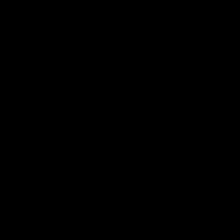

Image array shape: (224, 224, 3)
Min pixel value: 0
Max pixel value: 0


In [25]:
from PIL import Image
import numpy as np
from IPython.display import display


# Access an example and its PIL image
ex = ds['train'][0]
print("Example:", ex)

# Display the PIL image
display(ex["pil_image"])

# Convert PIL image to NumPy array
image_array = np.array(ex["pil_image"])

# Display image array shape and pixel values
print("Image array shape:", image_array.shape)
print("Min pixel value:", np.min(image_array))
print("Max pixel value:", np.max(image_array))

In [26]:
label = ds['train'][0]['label']
label

'progressor'

In [27]:
class_labels

ClassLabel(names=['nonprogressor', 'progressor'], id=None)

In [28]:
class_labels.str2int(label)

1

In [29]:
from transformers import ViTFeatureExtractor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [30]:
feature_extractor

ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [48]:
ds['train']

Dataset({
    features: ['label', 'split', 'image_path', 'pil_image'],
    num_rows: 4596
})

In [49]:
ex = ds['train'][400]
image = ex['pil_image']
feature_extractor(image, return_tensors='pt')

{'pixel_values': tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]])}

In [50]:
def process_example(example):
    inputs = feature_extractor(example['pil_image'], return_tensors='pt')
    inputs['label'] = example['label']
    return inputs

In [51]:
process_example(ds['train'][0])

{'pixel_values': tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]]), 'label': 'progressor'}

In [52]:
def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([x for x in example_batch['pil_image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['label'] = example_batch['label']
    return inputs

prepared_ds = ds.with_transform(transform)

In [54]:
prepared_ds['train'][0]

{'pixel_values': tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]),
 'label': 'progressor'}

In [55]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

In [56]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

In [57]:
class_labels.names

['nonprogressor', 'progressor']

In [58]:
from transformers import ViTForImageClassification

labels = class_labels.names #ds['train'].features['labels'].names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [73]:
# !pip install transformers[torch]
# !pip install transformers
# !pip install transformers[torch] accelerate --upgrade
# !pip install accelerate==0.20.3


In [74]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./vit-base-beans-demo-v5",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

ImportError: ignored

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    tokenizer=feature_extractor,
)

In [ ]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

In [ ]:
metrics = trainer.evaluate(prepared_ds['validation'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

In [ ]:
kwargs = {
    "finetuned_from": model.config._name_or_path,
    "tasks": "image-classification",
    "dataset": 'dcis-eila',
    "tags": ['image-classification'],
}

if training_args.push_to_hub:
    trainer.push_to_hub('🍻 cheers', **kwargs)
else:
    trainer.create_model_card(**kwargs)